# Bayesian spatial-temporal interaction model for Covid-19 

## Gemeinsame Arbeit der Arbeitsgruppe Neuroinformatik an der Universität Osnabrück und des  Supercomputing Centers Jülich 
[Acknowledgement](#another_cell)

<!--- Aktuelle Daten und Vorhersage der Neuinfizierungen mit COVID-19 für 25 Städte in Deutschland. Das Model beschreibt die Tages aktullen Daten basierend auf Daten des RKI  
<a href=" https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0/data?orderBy=Meldedatum">link (Daten)</a>. 
Das Model ist Bayesian das heist das es die Verteilung der Paramter schätzt und somit für verscheidene mögliche Szenarien die mit der aktuellen Datenlage kompatibel sind die Wahrscheinlichkeit berechnet. 
Dazu sind din der zeitlichen Verläufen die Beobachten Zahlen an Neuinfektionen pro Tag als schwarze Punkte eingezeichnet. Der Verlauf des wahrscheinlichsten Models ist in rot eingezeicghnet und die Konfidenz intervalle mit 25% und 75% mit einen organgen Intervall und einer gepunkteten Line eingezeichnet. -->

Aktuelle Daten und Vorhersage der Neuinfizierungen mit COVID-19 für 25 Städte in Deutschland. Das Model beschreibt die tagesaktuellen Daten basierend auf den
<a href=" https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0/data?orderBy=Meldedatum">Daten</a> des RKI  .
Das Model ist Bayesian das heist das es die Verteilung der Paramter schätzt und somit für verscheidene mögliche Szenarien die mit der aktuellen Datenlage kompatibel sind die Wahrscheinlichkeit berechnet.
Die Arbeit basiert auf einer Adaption des <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0225838#pone.0225838.ref009">BSTIM Models</a> angepasst an die COVID-19 Situation.

<iframe width="560" height="315" src="https://www.youtube.com/embed/8-AfYeosBW8" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("../src/")

from plot_curves import curves
from plot_curves_no_periodic import curves_no_periodic
from plot_temporal_contribution import temporal_contribution
from plot_interaction_kernel import interaction_kernel
from plot_interaction_kernel_appendix import interaction_kernel_app
from plot_curves_appendix import curves_appendix

## Beispiel-Modelle für zwei Städte
Unten sieht man die Daten und Vorhersagen für zwei Städte (Düsseldorf & Leipzig). Die schwarzen Punkte zeigen die tatsächlich beobachteten Neuinfektionen. Der Verlauf des wahrscheinlichsten Models ist in rot eingezeichnet und die Konfidenzintervalle mit 25% und 75% mit einem orangenem Intervall und einer gepunkteten Line eingezeichnet. Die gezeigten Daten starten am 01.03.2020. Das Modell wurde auf Daten vom 28.01.2020 bis zum 16.05.2020 trainiert. Rechts von der gestrichelten blauen Linie beginnen also die Vorhersagen des Modells. Die durchgezogene blaue Linie markiert den Beginn der Tage für den noch keine echten Zahlen vorliegen.

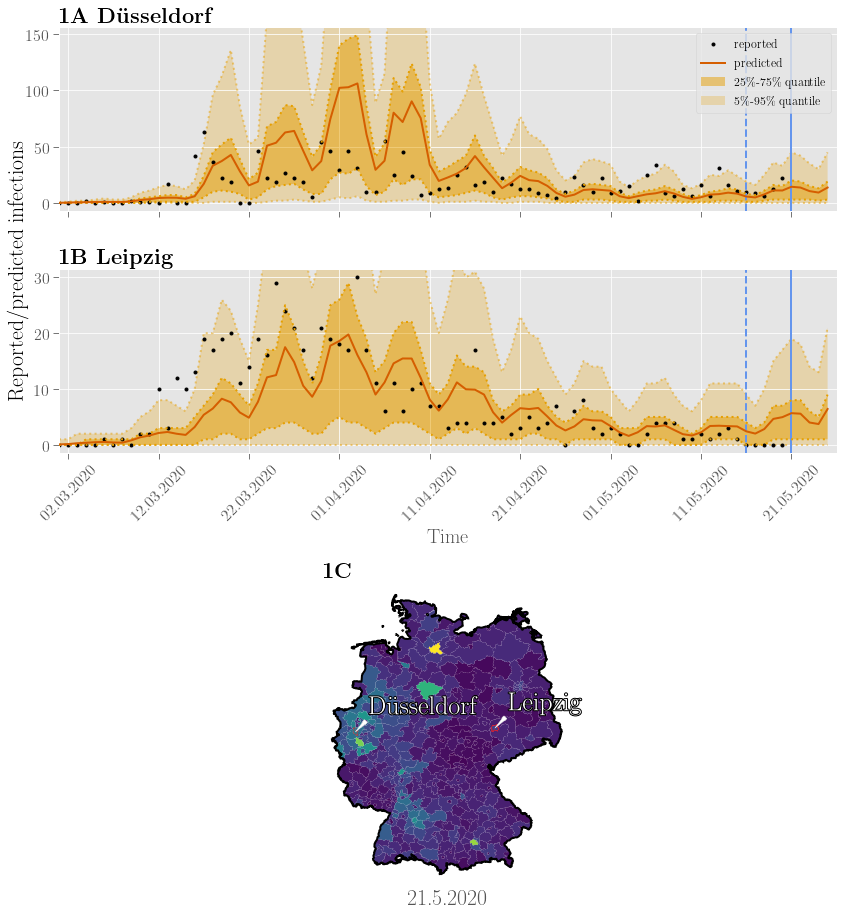

In [2]:
plt.close()
curves()

Das Modell benutzt eine periodische Komponente um die Fluktuationen in den Daten zu erklären, welche in erster Linie auf Unterschieden in den Datenübermittlungsprozessen der verschiedenen Landkreise beruht. Diese Komponente kann entfernt werden, sodass das Modell den eigentlichen Trend zeigt.

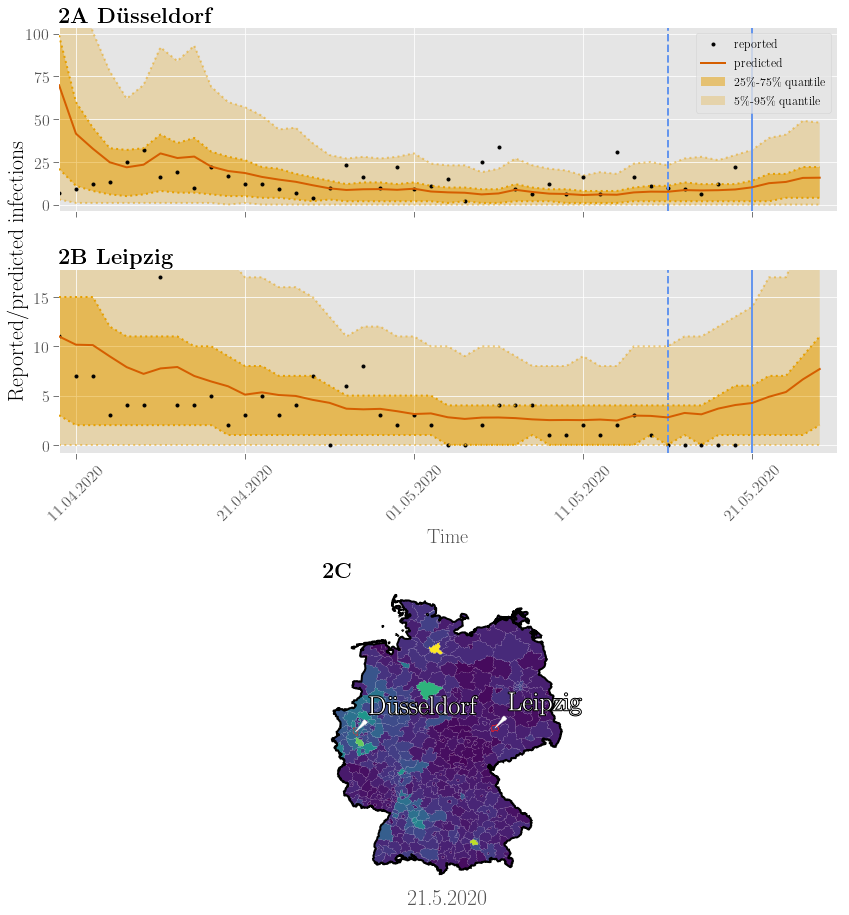

In [3]:
plt.close()
curves_no_periodic()

## Modell Informationen

Wir benutzen ein auf Wahrscheinlichkeiten beruhendes Modell um die beobachteten Daten zu modellieren.

Das Modell benutzt dabei zwei Klassen von vorhersagekräftigen Features. Zum einen, räumlich-zeitliche Features (Funktionen in Raum, Zeit oder beidem). Diese Features sind der rein zeitliche Trend in den Daten, eine periodische Komponente für die Fluktuationen, welhe durch das Datenübermittlungssystem verursacht wird und räumliche Komponenten welche spezifisch für die einzelnen Landkreise sind (z.B. demographische Verteilung, Legislation und verschiedene Reaktion auf die COVID-19 Situation.

Zum anderen modellieren wir einen räumlich-zeitlichen Interaktionseffekt als eine autoregressive Variable welche festhält wie eine beobachtete Infektion die Anzahl von weiteren Infektionen in ihrer Nachbarschaft beinflusst. Dies ist abhängig von Unterschieden im Verhalten von Patienten, Transmissionsvektoren, Inkubationszeiten und Infektionsdauer der betrachteten Krankheit (in unserem Falle COVID-19).

Auch ohne Ansteckungen können zuvor beobachtete Infektionen wertvolle indirekte Informationen in Form von latenten Variable bereitstellen, die die Vorhersage von zukünftigen Fällen ermöglichen. Dieser Effekt auf die zu erwartende Anzahl von Infektionen spiegelt sich wieder in der räumlichen und zeitlichen Distanz zu den zuvor beobachteten Fällen.

Der Interaktionseffekt erlaubt uns auszuwerten zu welchem Grad lokale Infektionsraten von Fällen in der Nachbarschaft beeinflusst werden. Zum Beispiel im Falle von kleinen Landkreisen die an große Städte angrenzen können diese Informationen die Zukunftsvorhersagen verbessern [2].

Der Interaktionseffekt ist so modelliert, dass er für alle Landkreise identisch ist.

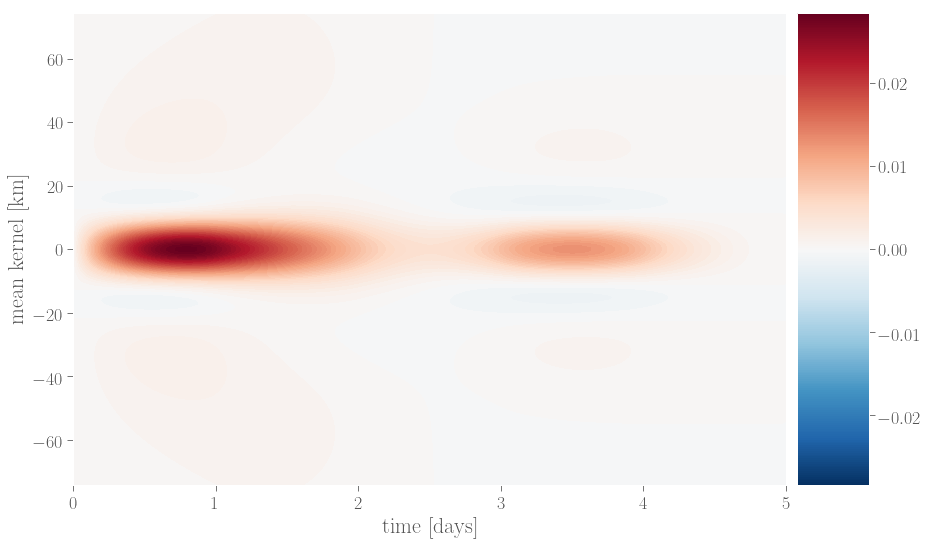

In [4]:
plt.close()
interaction_kernel()

## Interpretation der Interaktion

Die durchschnittliche Interkation während der COVID-19 Situation ist sehr lokal und ziemlich schnell. Eine positive Komponente die einen Anstieg von Infektionen basierend auf beobachteten Infektionen in naher Entfernung impliziert ist ersichtlich. Die räumliche Komponente beschränkt sich auf einen Radius von 6.25 km, die zeitiche Komponente auf einen Zeitraum von 3 Tagen.

## Das Modell

Das auf Wahrscheinlichkeiten beruhende Modell beschreibt die neu beobachteten Fälle pro Tag. Da epidemiologische Daten oft nach einer Poisson-Verteilung überdispersiert sind [3], dass heisst die Varianz übersteigt den Durchschnitt, nehmen wir an, dass die Fallzahlen nach einer negativen Binomial Verteilung um einen zu erwartenden Wert $\mu(t, x)$ verteilt sind, der in Zeit und Raum variiert.

$$\mu(x,t) = e^{ \left ( \sum_{i} w_i f_i(x,t) \right )}$$

Als Basisfunktion nutzen wir ein Polynom vierter/fünfter Ordnung um den Trend in den Daten zu modellieren.
Da es zum Ende der zu Verfügung stehenden Daten zu Verzögerungen in der Berichterstattung kommt modellieren wir einen Abfall der Fallzahlen mit Hilfe einer quadratischen Basisfunktion $f(t)=(t-4)^2 \ \text{für} \ t>t_{max-4}, \text{sonst} \ 0$.
Um die wöchentlichen Fluktuationen zu erklären fügen wir noch ein Polynom vierter Ordnung hinzu, welches sich alle sieben Tage wiederholt.

Alle diese Basisfunktionen sind linear gewichtet mit Gewichten geschätzt durch das trainieren auf die Daten mit Hilfe der Library PyMC3.

Zusammengefasst besteht das Modell aus 9 Basisfunktionen um die räumlichen und zeitlichen Dynamiken zu modellieren.

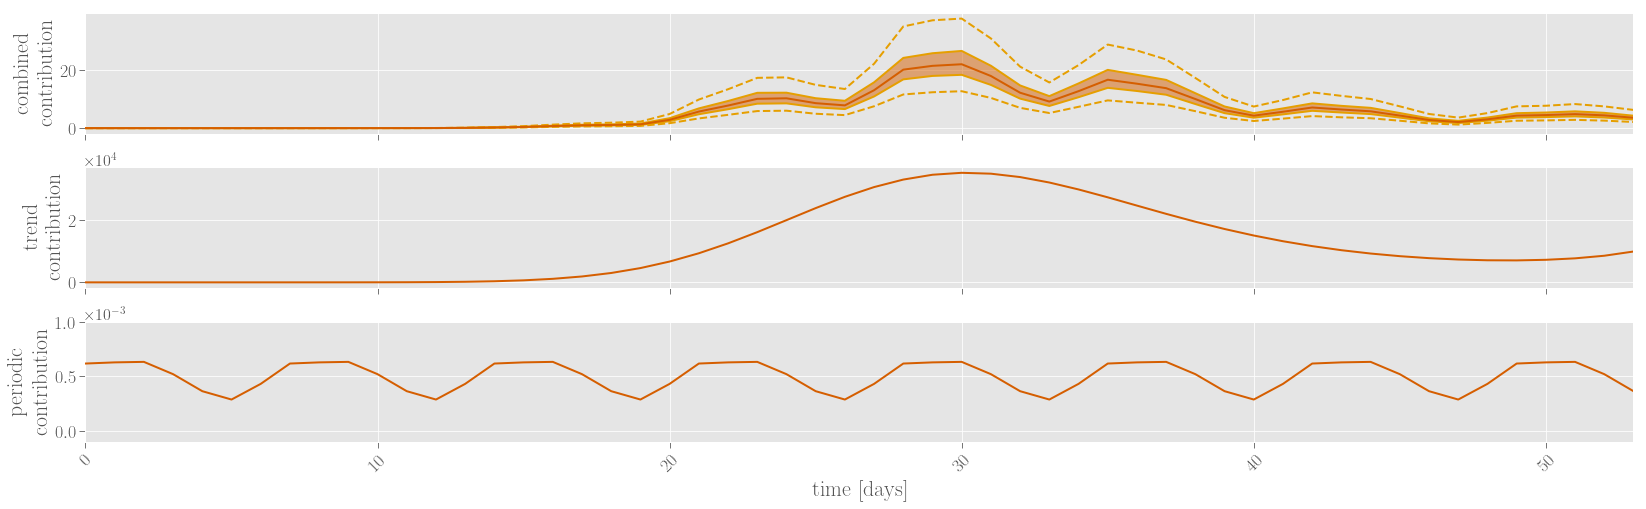

In [5]:
plt.close()
temporal_contribution()

## Modell für die Interaktion

Jeder beobachtete Fall beinhaltet wertvolle Informationen über die zu erwartende Anzahl von Fällen in der nahen Zukunft und in naher Entfernung. Wir nehmen an, dass dieser Effekt einer individuellen Infektion auf die Infektionsrate in der Zukunft festgehalten werden kann durch eine unbekannte Funktion $\kappa(d_{time}(t\star, t_k), d_{geo}(x\star, xk))$ welche wir im folgenden als Interaktionseffekt-Kernel bezeichnen werden. $(t_k, x_k)$ bezieht sich hierbei auf die Zeit und den Ort der k-ten Infektion und $(t\star, x\star)$ repräsentiert die Zeit und den Ort einer hypothetischen zukünftigen Infektion. $d_{geo}(x, y)$ repräsentiert die geographische Distanz zwischen den Orten $x$ und $y$, während $d_{time}(t, s)$ den zeitlichen Abstand zwischen den Zeitpunkten $t$ und $z$ beschreibt. Also ist $\kappa(\cdot, \cdot)$ ein radialer, zeit- und ortsunabhängiger Kernel, der nur von der räumlichen und zeitlichen Entfernung von zwei hypothetischen Fällen abhängt. Der Einfachheit halber nehmen wir an, dass die Interaktionseffekte basierend auf individuellen Infektionen sich linear aufsummieren.

Um in der Lage zu sein den räumlichen zeitlichen Interaktionskernel von den beobachtetn Daten zu lernen, approximieren wir den Kernel durch eine Linearkombination von räumlich-zeitlichen Basiskernel $\kappa_{i,j}$ mit Koeffizienten $w_i$ die von den Trainingsdaten gelernt werden können, indem wie den selben Monte Carlo Prozess nutzen wie für das Lernen aller anderen Parameter. Als räumliche Basisfunktionen nutzen wir eine Gauss Normalverteilung, zentriert in 0 und einer Standardabweichung von 6.25, 12.5, 25 und 50 (km). Die zeitliche Komponente des Kernels wird durch kubische Splines in insgesamt 4 Basisfunktionen modelliert, die ein Intervall von 5 Tagen abdecken.



## Monte Carlo Sampling Prozess

Das zuvor beschriebene Modell bestimmt die Verteilung des Posteriors über die Parameter durch die datenabhängige Likelihood und die Wahl der Priors. Wir halten diese Parameterverteilung in einer vollkommen Bayesian Art und Weise fest. Um dies zu erreichen nutzen wir Markov Chain Monte Carlo (MCMC) Methoden um unverzerrte Samples der Posterior-Verteilung zu generieren. Diese Samples können genutzt werden um die Performance des Modells zu evaluieren.

Unser Modell kombiniert Features, welche direkt beobachtet werden können (z.B. demographische Informationen) mit Features, die nur geschätzt werden können (z.B. Interaktionseffekte). Um die letzteren in das Modell zu integrieren, generieren wir Samples von der Verteilung der Interaktionseffekte wie im oberen Abschnitt beschrieben.

Der Sampling-Prozess generiert Samples von der Prior-Verteilung über die Parameter und kombiniert sie mit den Trainingsdaten und den zuvor generierten Samples der Interaktionseffekte um Samples der Posterior-Verteilung zu generieren Diese Samples der inferierten gemeinsamen Wahrscheinlichkeitsverteilung über die Parameter wir dann genutzt um Samples für die Posterior-Verteilung der Modell-Vorhersagen für die Testdaten zu generieren.

Wir benuzen dabei eine hamiltonische Monte Carlo Methode, No-U-Turn-Sampling, implementieren in der probablistischen Programmiersprache PyMC3.

### Appendix

Modelle und Vorhesagen für 25 repräsentative Landkreise und Städte.

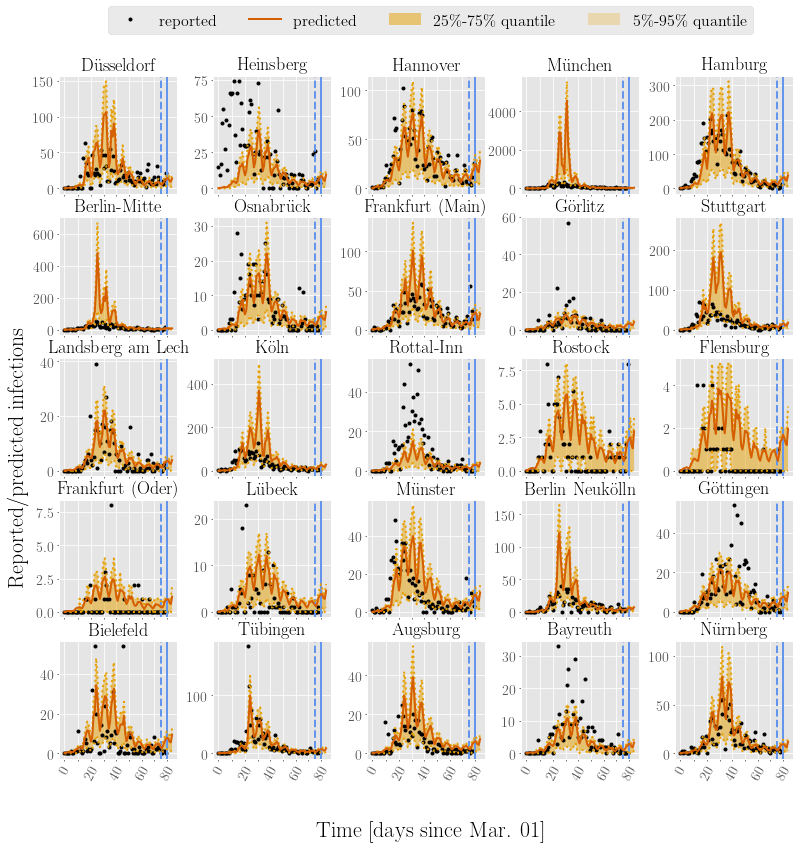

In [6]:
plt.close()
curves_appendix()

Sechs verschieden Interaktionseffekt-Kernels.

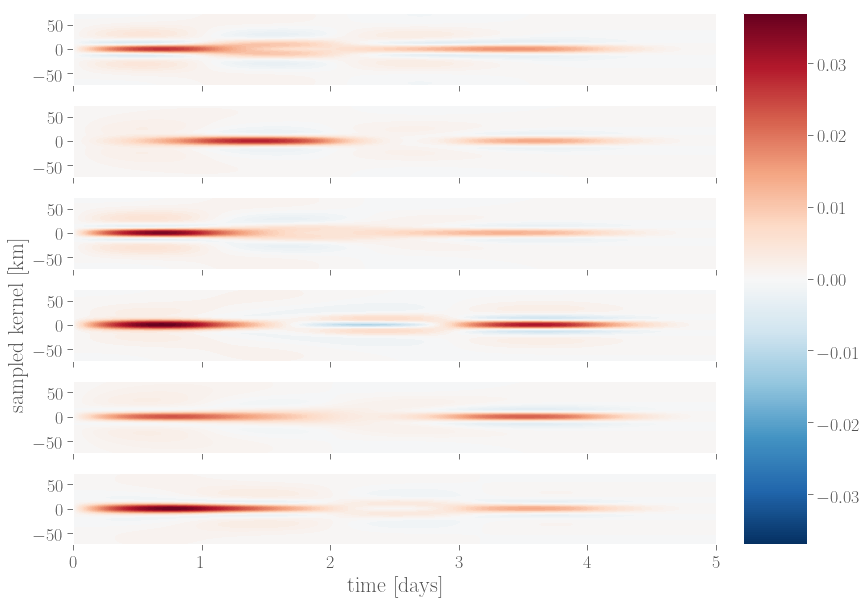

In [7]:
plt.close()
interaction_kernel_app()

## Acknowledgment
Diese Arbeit ist ein gemeinsames Projektder Arbeitsgruppe Neuroinformatik an der Universität Osnabrück (UOS) und des  Supercomputing Centers Jülich (JSC) . Wir danken dem Super-Computing-Center der RWTH-Aachen für die zu Verfügung gestellte Rechenzeit. Spezifisch danken wir den folgenden Mitwirkenden: Pascal Nieters (UOS), Dr. Daniel Rohe (JSC), Jens Henrik Göbbert (JSC) , Luke Effenberg (UOS), Björn Hagemeier (JSC), Kai Krajsek (JSC), Prof. Thomas Lippert (JSC), Prof. Gordon Pipa (UOS)
<a id='another_cell'></a>

## References 
(1) Stojanović, O., Leugering, J., Pipa, G., Ghozzi, S., & Ullrich, A. (2019). A Bayesian Monte Carlo approach for predicting the spread of infectious diseases. PloS one, 14(12).  

(2) Xia Y, Bjørnstad O, Grenfell B. Measles Metapopulation Dynamics: A Gravity Model for Epidemiological Coupling and Dynamics. The American Naturalist. 2004;164(2):267–281. pmid:15278849   

(3) Lee JH, Han G, Fulp W, Giuliano A. Analysis of overdispersed count data: application to the Human Papillomavirus Infection in Men (HIM) Study. Epidemiology & Infection. 2012;140(6):1087–1094. 